In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import sys
import os 
from scipy.sparse import linalg
from pathlib import Path
if torch.cuda.is_available():  
    device = "cuda" 
else:  
    device = "cpu" 

pi = torch.tensor(np.pi,dtype=torch.float64)
torch.set_default_dtype(torch.float64)

class model(nn.Module):
    """ ReLU k shallow neural network
    Parameters: 
    input size: input dimension
    hidden_size1 : number of hidden layers 
    num_classes: output classes 
    k: degree of relu functions
    """
    def __init__(self, input_size, hidden_size1, num_classes,k = 1):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias = False)
        self.k = k 
    def forward(self, x):
        u1 = self.fc2(F.relu(self.fc1(x))**self.k)
        return u1



In [21]:
def PiecewiseGQ1D_weights_points(x_l,x_r,Nx, order):
    """ Output the coeffients and weights for piecewise Gauss Quadrature 
    Parameters
    ----------
    x_l : float 
    left endpoint of an interval 
    
    x_r: float
    right endpoint of an interval 
    
    integration_intervals: int
    number of subintervals for integration
    
    Returns
    -------
    coef1_expand
    
    gw_expand
    
    integration_points
    """
    x,w = np.polynomial.legendre.leggauss(order)
    gx = torch.tensor(x).to(device)
    gx = gx.view(1,-1) # row vector 
    gw = torch.tensor(w).to(device)    
    gw = gw.view(-1,1) # Column vector 
    nodes = torch.linspace(x_l,x_r,Nx+1).view(-1,1).to(device) 
    coef1 = ((nodes[1:,:] - nodes[:-1,:])/2) # n by 1  
    coef2 = ((nodes[1:,:] + nodes[:-1,:])/2) # n by 1  
    coef2_expand = coef2.expand(-1,gx.size(1)) # Expand to n by p shape, -1: keep the first dimension n , expand the 2nd dim (columns)
    integration_points = coef1@gx + coef2_expand
    integration_points = integration_points.flatten().view(-1,1) # Make it a column vector
    gw_expand = torch.tile(gw,(Nx,1)) # rows: n copies of current tensor, columns: 1 copy, no change
    # Modify coef1 to be compatible with func_values
    coef1_expand = coef1.expand(coef1.size(0),gx.size(1))    
    coef1_expand = coef1_expand.flatten().view(-1,1)

    return coef1_expand.to(device) * gw_expand.to(device), integration_points.to(device)


def minimize_linear_layer_explicit_assemble(model,target,weights, integration_points,solver="direct"):
    """
    calls the following functions (dependency): 
    1. GQ_piecewise_2D
    input: the nn model containing parameter 
    1. define the loss function  
    2. take derivative to extract the linear system A
    3. call the cg solver in scipy to solve the linear system 
    output: sol. solution of Ax = b
    """
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
    weighted_basis_value_col = basis_value_col * weights 
    jac = weighted_basis_value_col.t() @ basis_value_col 
     
    rhs = weighted_basis_value_col.t() @ (target(integration_points)) 
    print("assembling the matrix time taken: ", time.time()-start_time) 
    start_time = time.time()    
    if solver == "cg": 
        sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
        sol = torch.tensor(sol).view(1,-1)
    elif solver == "direct": 
#         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
        sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
    elif solver == "ls":
        sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
        # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
    print("solving Ax = b time taken: ", time.time()-start_time)
    return sol 


def plot_solution_modified(r1,r2,model,x_test,u_true,name=None): 
    # Plot function: test results 
    u_model_cpu = model(x_test).cpu().detach()
    
    w = model.fc1.weight.data.squeeze()
    b = model.fc1.bias.data.squeeze()
    x_model_pt = (-b/w).view(-1,1)
    u_model_pt = model(x_model_pt).cpu().detach()
    plt.figure(dpi = 100)
    plt.plot(x_test.cpu(),u_model_cpu,'-.',label = "nn function")
    plt.plot(x_test.cpu(),u_true.cpu(),label = "true")
#     plt.plot(x_model_pt,u_model_pt,'.r')
    if name!=None: 
        plt.title(name)
    plt.legend()
    plt.show()


def plot_solution_adaptive(r1,r2,model,target,name=None): 
    # Plot function: test results 
    x_test = torch.linspace(r1,r2,200).view(-1,1).to(device)
    u_true = target(x_test)
    u_model_cpu = model(x_test).cpu().detach()
    
    w = model.fc1.weight.data.squeeze()
    b = model.fc1.bias.data.squeeze()
    x_model_pt = (-b/w).view(-1,1)
    u_model_pt = model(x_model_pt).cpu().detach()
    plt.figure(dpi = 200)
    plt.plot(x_test.cpu(),u_true.cpu(),label = "true")
    plt.plot(x_model_pt.cpu(),u_model_pt,'.',label = "nn function",markersize=3)
    # plt.plot(x_model_pt.cpu(),torch.ones(u_model_pt.size()) * 1.05* min(u_true.cpu()),'.',label = "nodes",markersize=4)
#     plt.plot(x_model_pt,u_model_pt,'.r')
    plt.xlim(r1,r2) 
    if name!=None: 
        plt.title(name)
    plt.legend()
    plt.show()

## OGA

In [5]:
# relu dictionary
def relu_dict(x_l,x_r,N):
    """generate relu dictionary parameters 
    
    Parameters
    ----------
    x_l: float 
    x_r: float
    N: int 
        number of degrbuhee of freedoms
        
    Returns
    torch tensor
        containing relu dictionary parameters, corresponds to nodal points
        
    """
    # w = 1 
    relu_dict_parameters = torch.zeros((N,2)).to(device)
    relu_dict_parameters[:N,0] = torch.ones(N)[:]
    relu_dict_parameters[:N,1] = torch.linspace(x_l,x_r,N+1)[:-1] # relu(x-bi)


    # relu_dict_parameters[N:,0] = -torch.ones(N)[:]
    # relu_dict_parameters[N:,1] = torch.linspace(x_l,x_r,N+1)[1:] # relu(x-bi)
    
    return relu_dict_parameters


def OGAL2FittingReLU1D(my_model,target,N,num_epochs,plot_freq = 10,Nx = 1024,order =5, k = 1, solver = 'direct'): 
    """ Orthogonal greedy algorithm using 1D ReLU dictionary over [-pi,pi]
    Parameters
    ----------
    my_model: 
        nn model 
    target: 
        target function
    num_epochs: int 
        number of training epochs 
    integration_intervals: int 
        number of subintervals for piecewise numerical quadrature 

    Returns
    -------
    err: tensor 
        rank 1 torch tensor to record the L2 error history  
    model: 
        trained nn model 
    """

    weights, integration_points = PiecewiseGQ1D_weights_points(x_l= 0,x_r= 1, Nx = Nx,order =order)

    err = torch.zeros(num_epochs+1)
    if my_model == None: 
        func_values = target(integration_points)
        num_neuron = 0
        list_a = []
        list_b = []
        list_w = []
    else: 
        func_values = target(integration_points) - my_model(integration_points).detach()
        bias = my_model.fc1.bias.detach().data
        weights = my_model.fc1.weight.detach().data
        num_neuron = int(bias.size(0))
        list_a = list(my_model.fc2.weight.detach().data)
        list_b = list(bias)
        list_w = list(weights)
        
    func_values_sqrd = func_values*func_values
    err[0]= torch.sum(func_values_sqrd*weights)**0.5
    start_time = time.time()
    
    solver = "direct"
    print("using linear solver: ",solver)
    relu_dict_parameters = relu_dict(-pi,pi,N).to(device) 
    for i in range(num_epochs): 
        print('epoch: ',i+1)
        if num_neuron == 0: 
            func_values = target(integration_points)
        else: 
            func_values = target(integration_points) - my_model(integration_points).detach()

        weight_func_values = func_values*weights

#         basis_values = F.relu(integration_points - bi).T # uses broadcasting
        basis_values = (F.relu(relu_dict_parameters[:,0] *integration_points - relu_dict_parameters[:,1])**k).T # uses broadcasting
        
        output = torch.abs(torch.matmul(basis_values,weight_func_values)) # 

        neuron_index = torch.argmax(output.flatten())
        
        list_w.append(relu_dict_parameters[neuron_index,0])
        list_b.append(-relu_dict_parameters[neuron_index,1])
        num_neuron += 1
        my_model = model(1,num_neuron,1,k).to(device)
        my_model.fc1.weight.data[:,0] = torch.tensor(list_w)[:]
        my_model.fc1.bias.data[:] = torch.tensor(list_b)[:]
#         sol = minimize_linear_layer(my_model,target,solver,Nx,order)
        sol = minimize_linear_layer_explicit_assemble(my_model,target,weights, integration_points,solver=solver)
        my_model.fc2.weight.data[0,:] = sol[:]
        if (i+1)%plot_freq == 0: 
            x_test = torch.linspace(-pi,pi,200).view(-1,1).to(device)
            u_true = target(x_test)
            plot_solution_modified(-pi,pi,my_model,x_test,u_true)
        func_values = target(integration_points) - my_model(integration_points).detach()
        func_values_sqrd = func_values*func_values
        err[i+1]= torch.sum(func_values_sqrd*weights)**0.5
    print("time taken: ",time.time() - start_time)
    return err, my_model



##

# relu dictionary
def relu_dict_MC(x_l,x_r,N):
    """generate relu dictionary parameters 
    
    Parameters
    ----------
    x_l: float 
    x_r: float
    N: int 
        number of degree of freedoms
        
    Returns
    torch tensor
        containing relu dictionary parameters, corresponds to nodal points
        
    """
    # w = 1 
    relu_dict_parameters = torch.zeros((N,2)).to(device)
    relu_dict_parameters[:N,0] = torch.ones(N)[:]
    relu_dict_parameters[:N,1] = torch.rand(N)*(x_r-x_l) + x_l # relu(x-bi) 
    # torch.linspace(x_l,x_r,N+1)[:-1] # relu(x-bi)
    return relu_dict_parameters

def generate_relu_dict4plusD_sphere(dim, s,N0): # 
    samples = torch.randn(s*N0,dim +1) 
    samples = samples/samples.norm(dim=1,keepdim=True)  
    Wb = samples 
    return Wb 

def generate_relu_dict_1D_semicircle(s,N0):
    theta = (torch.rand(s*N0) - 0.5) * torch.pi  # [-π/2, π/2]
    # theta = (torch.linspace(0,1,s*N0+1)- 0.5)* torch.pi  # [-π/2, π/2]
    Wb = torch.stack([torch.cos(theta), torch.sin(theta)], dim=1)
    return Wb

def OGAL2FittingReLU1D_MC(my_model,target,N0,num_epochs,plot_freq = 10,Nx = 1024, order = 3, k = 1, solver = 'direct'): 
    """ Orthogonal greedy algorithm using 1D ReLU dictionary over [-pi,pi]
    Parameters
    ----------
    my_model: 
        nn model 
    target: 
        target function
    num_epochs: int 
        number of training epochs 
    integration_intervals: int 
        number of subintervals for piecewise numerical quadrature 

    Returns
    -------
    err: tensor 
        rank 1 torch tensor to record the L2 error history  
    model: 
        trained nn model 
    """
    x_l = 0 
    x_r = 1 
    weights, integration_points = PiecewiseGQ1D_weights_points(x_l= x_l ,x_r= x_r,Nx = Nx, order = order)

    err = torch.zeros(num_epochs+1)
    if my_model == None: 
        func_values = target(integration_points)
        num_neuron = 0
        list_a = []
        list_b = []
        list_w = []
    else: 
        func_values = target(integration_points) - my_model(integration_points).detach()
        bias = my_model.fc1.bias.detach().data
        weights = my_model.fc1.weight.detach().data
        num_neuron = int(bias.size(0))
        list_a = list(my_model.fc2.weight.detach().data)
        list_b = list(bias)
        list_w = list(weights)
        
    func_values_sqrd = func_values*func_values
    err[0]= torch.sum(func_values_sqrd*weights)**0.5
    start_time = time.time()
    
    for i in range(num_epochs): 
        print('epoch ',i + 1 )
        # relu_dict_parameters = relu_dict_MC(-pi,pi,N0).to(device)
#         relu_dict_parameters = generate_relu_dict4plusD_sphere(1,1, N0).to(device) 
        relu_dict_parameters = generate_relu_dict_1D_semicircle(1,N0).to(device)
        if num_neuron == 0: 
            func_values = target(integration_points)
        else: 
            func_values = target(integration_points) - my_model(integration_points).detach()

        weight_func_values = func_values*weights

#         basis_values = F.relu(integration_points - bi).T # uses broadcasting
        basis_values = (F.relu(relu_dict_parameters[:,0] *integration_points - relu_dict_parameters[:,1])**k).T # uses broadcasting
        
        output = torch.abs(torch.matmul(basis_values,weight_func_values)) # 

        neuron_index = torch.argmax(output.flatten())
        
        list_w.append(relu_dict_parameters[neuron_index,0])
        list_b.append(-relu_dict_parameters[neuron_index,1])
        num_neuron += 1
        my_model = model(1,num_neuron,1,k).to(device)
        my_model.fc1.weight.data[:,0] = torch.tensor(list_w)[:]
        my_model.fc1.bias.data[:] = torch.tensor(list_b)[:]
#         sol = minimize_linear_layer(my_model,target,solver, Nx, order)
        sol = minimize_linear_layer_explicit_assemble(my_model,target,weights, integration_points,solver=solver)
        my_model.fc2.weight.data[0,:] = sol[:]
        if (i+1)%plot_freq == 0: 
            x_test = torch.linspace(x_l,x_r,200).view(-1,1).to(device)
            u_true = target(x_test)
            plot_solution_modified(x_l,x_r,my_model,x_test,u_true)
        func_values = target(integration_points) - my_model(integration_points).detach()
        func_values_sqrd = func_values*func_values
        err[i+1]= torch.sum(func_values_sqrd*weights)**0.5
    # print("time taken: ",time.time() - start_time)
    return err, my_model

# relu dictionary


In [8]:
def show_convergence_order(err_l2,exponent,dict_size, filename,write2file = False):
    
    if write2file:
        file_mode = "a" if os.path.exists(filename) else "w"
        f_write = open(filename, file_mode)
    
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err_l2[i] for i in neuron_nums ]
#     err_list2 = [err_h10[i] for i in neuron_nums ] 
    # f_write.write('M:{}, relu {} \n'.format(M,k))
    if write2file:
        f_write.write('dictionary size: {}\n'.format(dict_size))
        f_write.write("neuron num \t\t error \t\t order \t\t h10 error \\ order \n")
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(err_list):
        if i == 0: 
            # print(neuron_nums[i], end = "\t\t")
            # print(item, end = "\t\t")
            
            # print("*")
            print("{} \t\t {:.6f} \t\t *  \n".format(neuron_nums[i],item ) )
            if write2file: 
                f_write.write("{} \t\t {} \t\t * \t\t \n".format(neuron_nums[i],item ))
        else: 
            # print(neuron_nums[i], end = "\t\t")
            # print(item, end = "\t\t") 
            # print(np.log(err_list[i-1]/err_list[i])/np.log(2))
            print("{} \t\t {:.6f} \t\t {:.6f} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2) ) )
            if write2file: 
                f_write.write("{} \t\t {} \t\t {} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2) ))
    if write2file:     
        f_write.write("\n")
        f_write.close()

def show_convergence_order_latex(err_l2,exponent,k=1,d=1): 
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err_l2[i] for i in neuron_nums ]
#     err_list2 = [err_h10[i] for i in neuron_nums ] 
    # f_write.write('M:{}, relu {} \n'.format(M,k))
    # f_write.write('randomized dictionary size: {}\n'.format(N))
    # f_write.write("neuron num \t\t error \t\t order \t\t h10 error \\ order \n")
    l2_order = -1/2-(2*k + 1)/(2*d)
#     h10_order = -1/2-(2*(k-1) + 1)/(2*d)
#     print("neuron num  & \t $\|u-u_n \|_{L^2}$ & \t order $O(n^{{{}})$ & \t $ | u -u_n |_{H^1}$ & \t order $O(n^{{{}})$ \\\ \hline \hline ".format(l2_order,h10_order))
    print("neuron num  & \t $\\|u-u_n \\|_{{L^2}}$ & \t order $O(n^{{{:.2f}}})$  \\\\ \\hline \\hline ".format(l2_order))
    for i, item in enumerate(err_list):
        if i == 0: 
            # print(neuron_nums[i], end = "\t\t")
            # print(item, end = "\t\t")

            # print("*")
            print("{} \t\t & {:.6f} &\t\t *  \\\ \hline  \n".format(neuron_nums[i],item) )   
            # f_write.write("{} \t\t {} \t\t * \t\t {} \t\t * \n".format(neuron_nums[i],item, err_list2[i] ))
        else: 
            # print(neuron_nums[i], end = "\t\t")
            # print(item, end = "\t\t") 
            # print(np.log(err_list[i-1]/err_list[i])/np.log(2))
            print("{} \t\t &  {:.3e} &  \t\t {:.2f} \\\ \hline  \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2) ) )
            # f_write.write("{} \t\t {} \t\t {} \t\t {} \t\t {} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2) ))
    # f_write.write("\n")
    # f_write.close()

## randomized 

epoch  1
assembling the matrix time taken:  0.0002639293670654297
solving Ax = b time taken:  0.00011086463928222656
epoch  2
assembling the matrix time taken:  0.00037407875061035156
solving Ax = b time taken:  0.00010895729064941406
epoch  3
assembling the matrix time taken:  0.0003249645233154297
solving Ax = b time taken:  0.0001201629638671875
epoch  4
assembling the matrix time taken:  0.0005319118499755859
solving Ax = b time taken:  0.00011897087097167969
epoch  5
assembling the matrix time taken:  0.0003421306610107422
solving Ax = b time taken:  0.00010895729064941406
epoch  6
assembling the matrix time taken:  0.0003325939178466797
solving Ax = b time taken:  0.00010514259338378906
epoch  7
assembling the matrix time taken:  0.0003490447998046875
solving Ax = b time taken:  0.00011491775512695312
epoch  8
assembling the matrix time taken:  0.00030803680419921875
solving Ax = b time taken:  0.00010585784912109375
epoch  9
assembling the matrix time taken:  0.00036787986755371

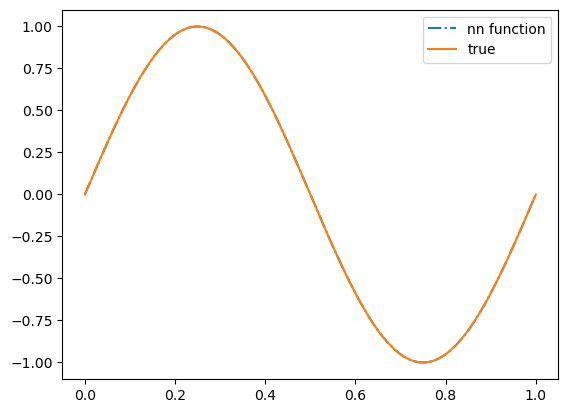

neuron num 		 error 		 order
4 		 0.135377 		 *  

8 		 0.023702 		 2.513896 

16 		 0.005292 		 2.163236 

32 		 0.001242 		 2.091100 

64 		 0.000297 		 2.064671 

128 		 0.000074 		 2.010110 

neuron num  & 	 $\|u-u_n \|_{L^2}$ & 	 order $O(n^{-2.00})$  \\ \hline \hline 
4 		 & 0.135377 &		 *  \\ \hline  

8 		 &  2.370e-02 &  		 2.51 \\ \hline  

16 		 &  5.292e-03 &  		 2.16 \\ \hline  

32 		 &  1.242e-03 &  		 2.09 \\ \hline  

64 		 &  2.969e-04 &  		 2.06 \\ \hline  

128 		 &  7.370e-05 &  		 2.01 \\ \hline  



In [28]:
def target(x):
    return torch.sin(2*pi * x)

function_name = "sine1d" 
Nx = 2**10
order = 3    
filename_write = "1DMCOGA-{}-order.txt".format(function_name)
f_write = open(filename_write, "a")
f_write.write("\n")
f_write.close() 

save = True  
write2file = True 

for N in [2**11]: # 2**12,2**14
    
    f_write = open(filename_write, "a")
    my_model = None 
    exponent = 7
    num_epochs = 2**exponent
    plot_freq = num_epochs 
    relu_k = 1 
    err_QMC2, my_model = OGAL2FittingReLU1D_MC(None,target,N,num_epochs,plot_freq, Nx, order, k =relu_k, solver = "direct")

    if save: 
        folder = 'data/'
        filename = folder + 'err_OGA_1D_{}_neuron_{}_N_{}_randomized.pt'.format(function_name,num_epochs,N)
        torch.save(err_QMC2,filename) 
        folder = 'data/'
        filename = folder + 'model_OGA_1D_{}_neuron_{}_N_{}_randomized.pt'.format(function_name,num_epochs,N)
        torch.save(my_model.state_dict(),filename)
        
    show_convergence_order(err_QMC2,exponent,N,filename_write,write2file = write2file)
    show_convergence_order_latex(err_QMC2,exponent,k=relu_k,d=1)
    

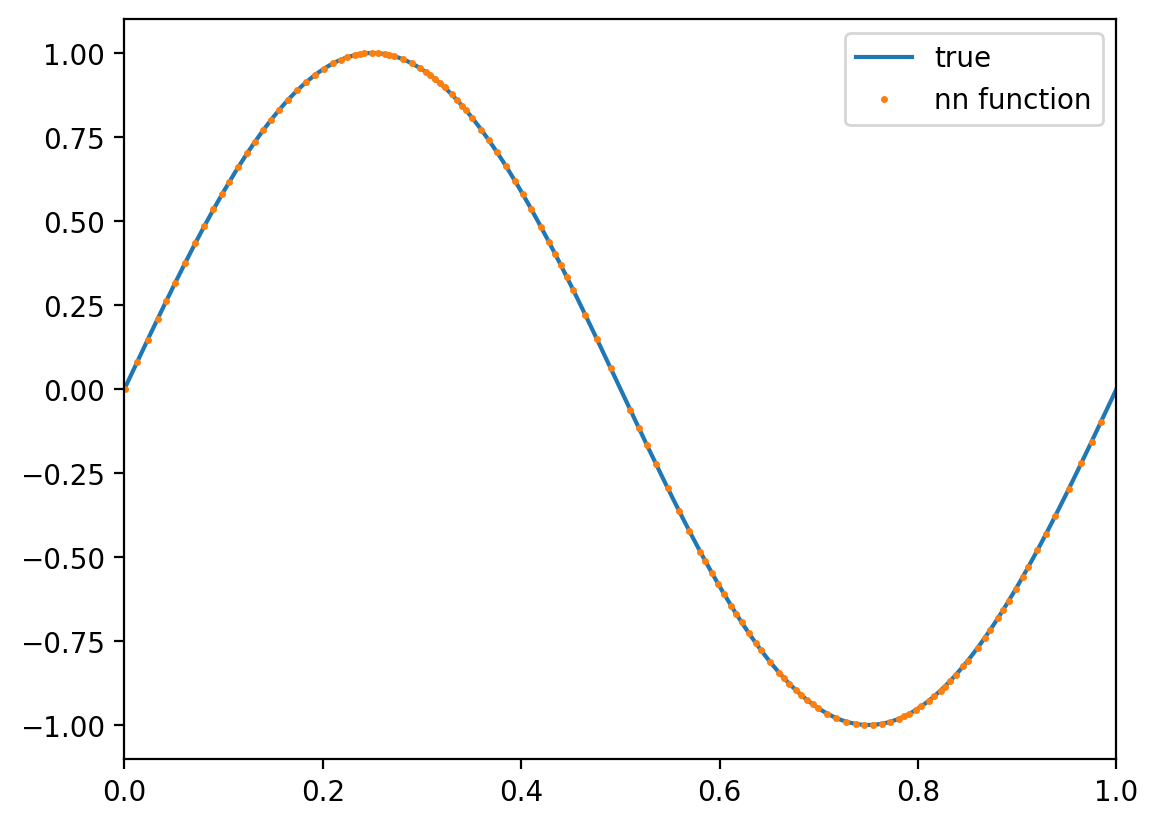

In [30]:
plot_solution_adaptive(0, 1, my_model, target, name=None)

## An oscillatory example  (added to thesis defense)

In [38]:


def target(x):
    return 10*(torch.sin(2*pi*x) + torch.sin(2*pi*3*x)) + 10*( \
            torch.sin(2*pi*4*x) + torch.sin(2*pi*9*x) + torch.sin(2*pi*13*x)- torch.sin(2*pi*x) - torch.sin(2*pi*3*x) \
            )* torch.heaviside(x-0.5,torch.tensor([0.0]))


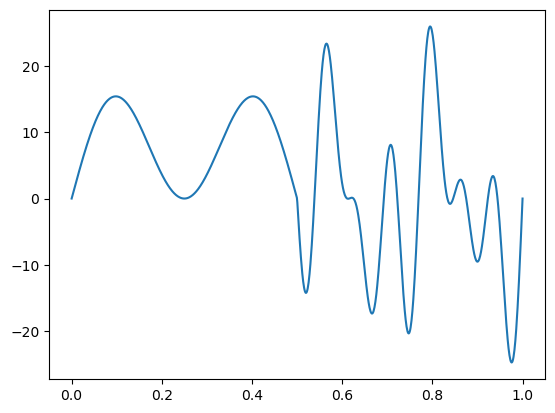

In [39]:
x_coord = torch.linspace(0,1,1000)
u_true = target(x_coord) 
plt.plot(x_coord,u_true)
plt.show() 

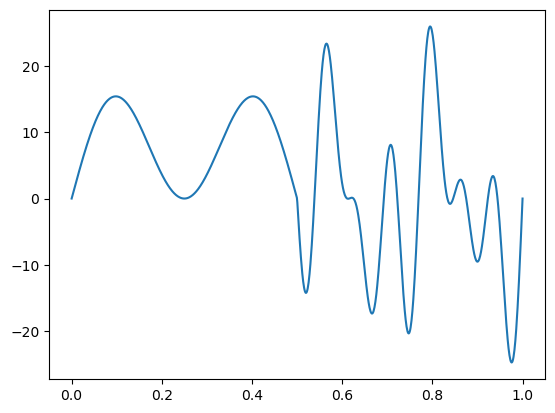

epoch  1
assembling the matrix time taken:  0.00864100456237793
solving Ax = b time taken:  0.000225067138671875
epoch  2
assembling the matrix time taken:  0.0022058486938476562
solving Ax = b time taken:  0.00015807151794433594
epoch  3
assembling the matrix time taken:  0.0015301704406738281
solving Ax = b time taken:  0.00012683868408203125
epoch  4
assembling the matrix time taken:  0.001744985580444336
solving Ax = b time taken:  0.0003693103790283203
epoch  5
assembling the matrix time taken:  0.002079010009765625
solving Ax = b time taken:  0.0001277923583984375
epoch  6
assembling the matrix time taken:  0.00109100341796875
solving Ax = b time taken:  0.00011420249938964844
epoch  7
assembling the matrix time taken:  0.0047571659088134766
solving Ax = b time taken:  0.00015282630920410156
epoch  8
assembling the matrix time taken:  0.002753019332885742
solving Ax = b time taken:  0.00012421607971191406
epoch  9
assembling the matrix time taken:  0.007720947265625
solving Ax = 

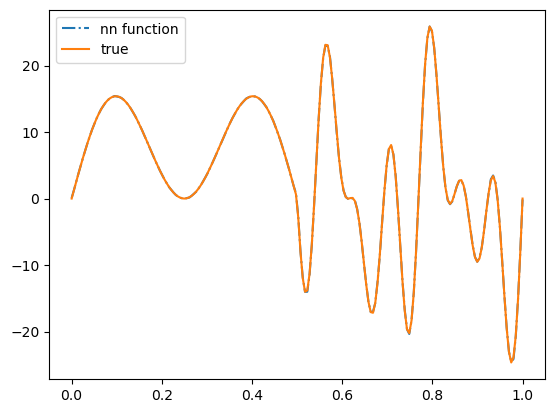

neuron num 		 error 		 order
4 		 9.030018 		 *  

8 		 6.385628 		 0.499900 

16 		 4.329298 		 0.560695 

32 		 1.020454 		 2.084923 

64 		 0.223305 		 2.192120 

128 		 0.055327 		 2.012962 

neuron num  & 	 $\|u-u_n \|_{L^2}$ & 	 order $O(n^{-2.00})$  \\ \hline \hline 
4 		 & 9.030018 &		 *  \\ \hline  

8 		 &  6.386e+00 &  		 0.50 \\ \hline  

16 		 &  4.329e+00 &  		 0.56 \\ \hline  

32 		 &  1.020e+00 &  		 2.08 \\ \hline  

64 		 &  2.233e-01 &  		 2.19 \\ \hline  

128 		 &  5.533e-02 &  		 2.01 \\ \hline  



In [41]:
def target(x):
    return 10*(torch.sin(2*pi*x) + torch.sin(2*pi*3*x)) + 10*( \
            torch.sin(2*pi*4*x) + torch.sin(2*pi*9*x) + torch.sin(2*pi*13*x)- torch.sin(2*pi*x) - torch.sin(2*pi*3*x) \
            )* torch.heaviside(x-0.5,torch.tensor([0.0]))

x_coord = torch.linspace(0,1,1000)
u_true = target(x_coord) 
plt.plot(x_coord,u_true)
plt.show() 

function_name = "oscillatory1d" 
Nx = 2**11
order = 3    
filename_write = "1DMCOGA-{}-order.txt".format(function_name)
f_write = open(filename_write, "a")
f_write.write("\n")
f_write.close() 

save = True  
write2file = True 

for N in [2**11]: # 2**12,2**14
    
    f_write = open(filename_write, "a")
    my_model = None 
    exponent = 7
    num_epochs = 2**exponent
    plot_freq = num_epochs 
    relu_k = 1 
    err_QMC2, my_model = OGAL2FittingReLU1D_MC(None,target,N,num_epochs,plot_freq, Nx, order, k =relu_k, solver = "direct")

    if save: 
        folder = 'data/'
        filename = folder + 'err_OGA_1D_{}_neuron_{}_N_{}_randomized.pt'.format(function_name,num_epochs,N)
        torch.save(err_QMC2,filename) 
        folder = 'data/'
        filename = folder + 'model_OGA_1D_{}_neuron_{}_N_{}_randomized.pt'.format(function_name,num_epochs,N)
        torch.save(my_model.state_dict(),filename)
        
    show_convergence_order(err_QMC2,exponent,N,filename_write,write2file = write2file)
    show_convergence_order_latex(err_QMC2,exponent,k=relu_k,d=1)
    

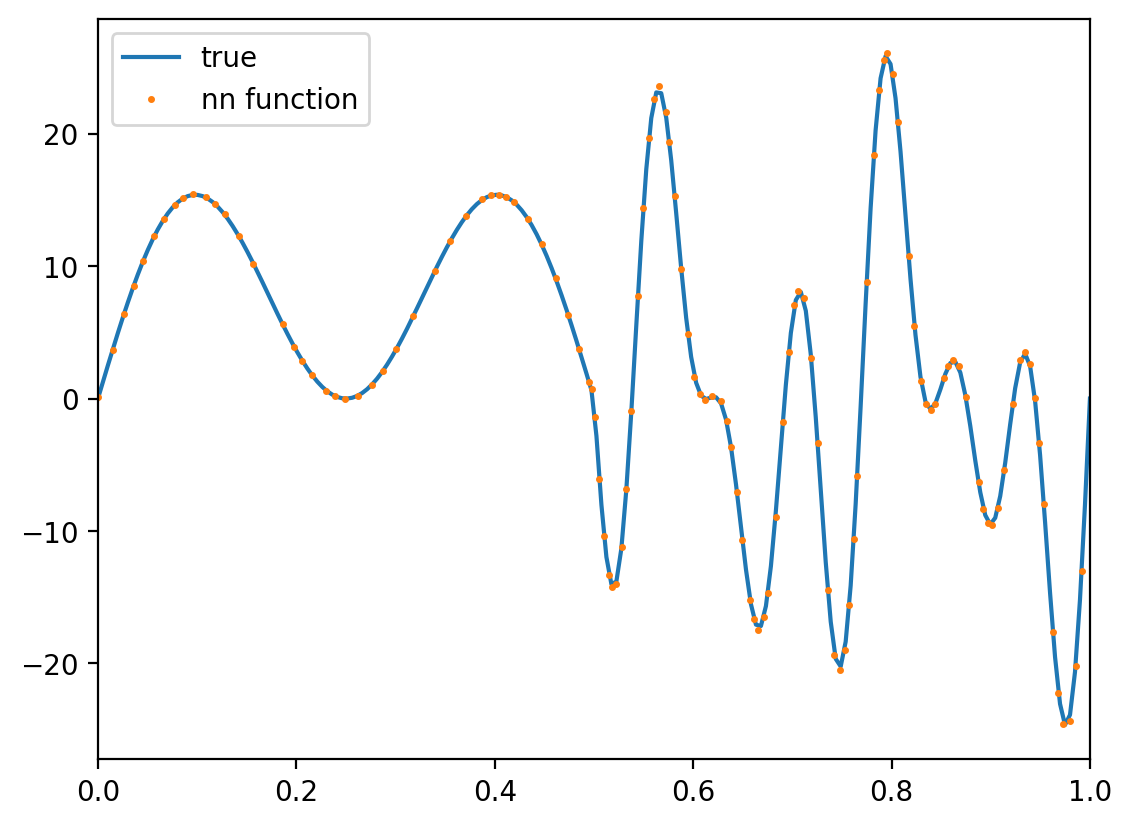

In [42]:
plot_solution_adaptive(0, 1, my_model, target, name=None)